In [35]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pathlib
import PIL
import matplotlib.pyplot as plt
import seaborn as sb

In [56]:
train_path = pathlib.Path("chest_xray/train")
val_path = pathlib.Path("chest_xray/val")
test_path = pathlib.Path("chest_xray/test")

In [57]:
# count train file
image_count = len(list(train_path.glob("**/*.jpeg")))
image_count

5216

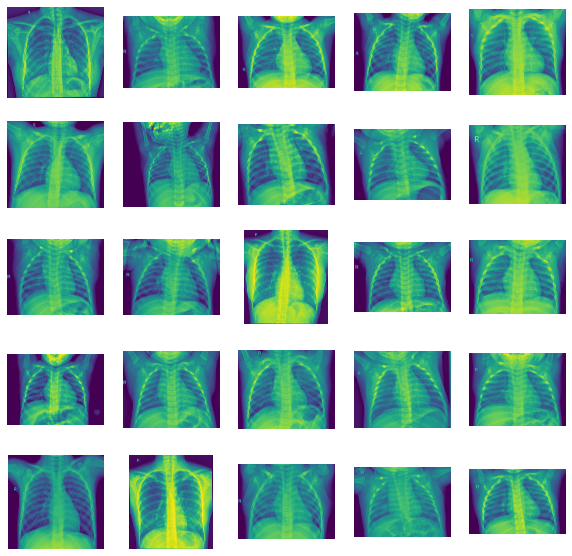

In [58]:
# check the 25 pictures of NORMAL
# 정상 사진
normal_vis = list(train_path.glob("NORMAL/*.jpeg"))
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = PIL.Image.open(str(normal_vis[i]))
    plt.imshow(img)
    plt.axis(False)

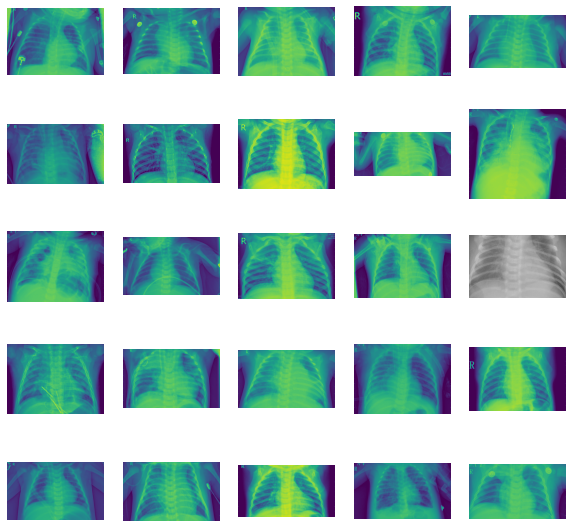

In [59]:
# check 25 pictures of PNEUMONIA
# 비정상 사진

PNEUMONIA_vis = list(train_path.glob("PNEUMONIA/*.jpeg"))
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = PIL.Image.open(str(PNEUMONIA_vis[i]))
    plt.imshow(img)
    plt.axis(False)

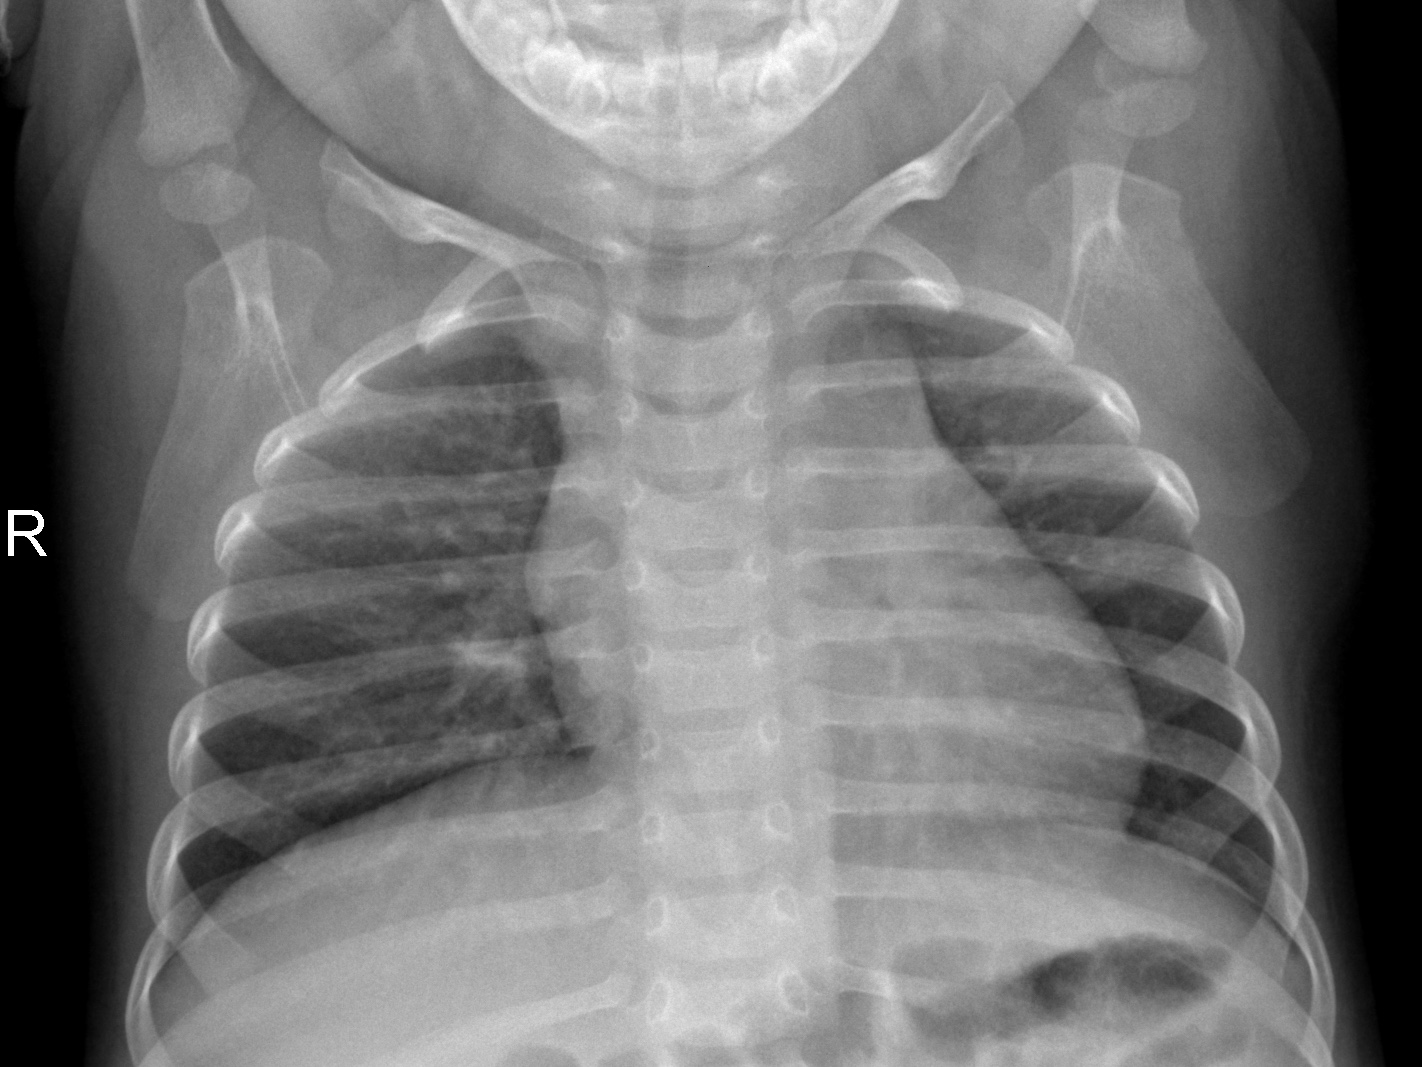

In [60]:
# 정상 가슴의 사진 확인
PIL.Image.open(str(normal_vis[1]))

In [42]:
# 
batch_size = 100
image_width = 128
image_height = 128
random_state = 100

In [61]:
# 데이터 준비

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [62]:
class_names = train_data.class_names
class_names

['NORMAL', 'PNEUMONIA']

AttributeError: 'BatchDataset' object has no attribute 'head'

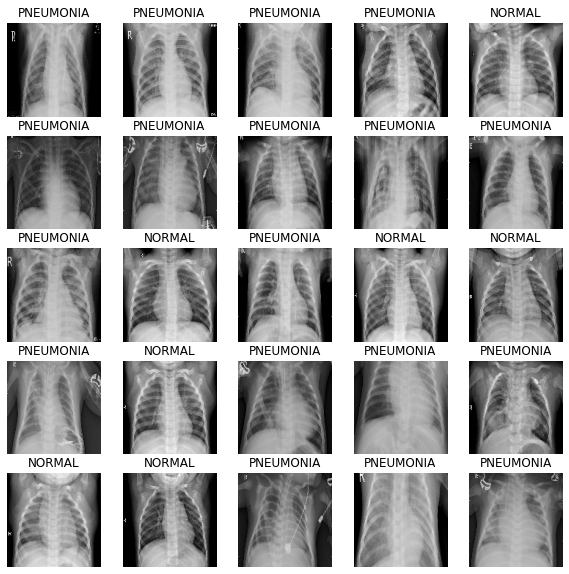

In [63]:
plt.figure(figsize = (10, 10))
for images, labels in train_data.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis(False)
# pneumonia를 1로 normal을 0으로 라벨링


53

In [64]:
# 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)]
)

In [65]:
data_preprocessing_resnet = tf.keras.applications.resnet.preprocess_input

base_model_resnet = tf.keras.applications.resnet.ResNet50(
    input_shape = (image_height, image_width, 3),
    include_top = False,
    weights = "imagenet"
)

In [48]:
base_model_resnet.trainable = False

In [66]:
# 모델 만들기
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation = "sigmoid")

In [67]:
inputs = tf.keras.Input((128, 128, 3))
x = data_augmentation(inputs)
x = data_preprocessing_resnet(x)
x = base_model_resnet(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)


In [68]:
model_resnet = tf.keras.Model(inputs = inputs, outputs = outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)

In [69]:
model_resnet.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [70]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)

In [71]:
history_resnet = model_resnet.fit(train_data, validation_data = val_data, batch_size = 100, epochs = 1000, callbacks=[early_stopping])

Epoch 1/1000


InvalidArgumentError: Cannot assign a device for operation model_3/sequential_2/random_rotation_2/stateful_uniform/RngReadAndSkip: Could not satisfy explicit device specification '' because the node {{colocation_node model_3/sequential_2/random_rotation_2/stateful_uniform/RngReadAndSkip}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
RngReadAndSkip: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  model_3_sequential_2_random_rotation_2_stateful_uniform_rngreadandskip_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  model_3/sequential_2/random_rotation_2/stateful_uniform/RngReadAndSkip (RngReadAndSkip) 

	 [[{{node model_3/sequential_2/random_rotation_2/stateful_uniform/RngReadAndSkip}}]] [Op:__inference_train_function_44213]